# Rotations, Negative Eigenvalues, and Newton Method in Tensor Network Renormalization Group 
## Reproduction of some of the paper results

This notebook reproduces some of the results presented in the paper "Rotations, Negative Eigenvalues, and Newton Method in Tensor Network Renormalization Group." Let us start with installing dependencies and ensuring the correct environment is used.  

In [1]:
using Pkg
Pkg.activate(".")
include("install_packages.jl")
include("Tools.jl")
include("KrylovTechnical.jl")
include("GaugeFixing.jl");

  Activating project at `~/Codes/GILT_TNR_R`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Changes to `~/Codes/GILT_TNR_R/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Changes to `~/Codes/GILT_TNR_R/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Changes to `~/Codes/GILT_TNR_R/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Changes to `~/Codes/GILT_TNR_R/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Changes to `~/Codes/GILT_TNR_R/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Changes to `~/Codes/GILT_TNR_R/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Codes/GILT_TNR_R/Project.toml`
  No Cha

Now, let us reproduce Figure 4 from the paper. We run the critical_temperature.jl script with default values by calling "julia --project Lab/critical_temperature.jl". The script will save Figure 4 in the trajectory_plots folder. 

In [ ]:
run(`julia --project Lab/critical_temperature.jl`)

After this, we can reproduce Figure 5. First, we define two distance functions. Function embedded_distance will compute the distance between two tensors, even with different leg dimensions, by extending tensors by zeros. Function embedded_distance_with_additional_sign_fixing does the same, but additionally applies relative discrete gauge fixing. The code is suboptimal, but we need these functions only once in this computation.

In [2]:
function embedded_distance(tens1, tens2)
	if tens1.qhape != tens2.qhape
		throw("nonequal qhapes, code is not suited for such a situation.")
	end
	extended_shape = max.(tens1.shape, tens2.shape)
	tens1_ext = extend_blocks_by_zeros(tens1, extended_shape)
	tens2_ext = extend_blocks_by_zeros(tens2, extended_shape)
	tens1_ext - tens2_ext |> norm
end

function embedded_distance_with_additional_sign_fixing(tens1, tens2)
	if tens1.qhape != tens2.qhape
		throw("nonequal qhapes, code is not suited for such a situation.")
	end
	extended_shape = max.(tens1.shape, tens2.shape)
	tens1_ext = (extend_blocks_by_zeros(tens1, extended_shape) |> ju_to_py)
	tens2_ext = (extend_blocks_by_zeros(tens2, extended_shape) |> ju_to_py)
	tens2_f, tens2_accepted_elements, _ = fix_discrete_gauge(tens2_ext)
	tens1_f, _ = fix_discrete_gauge(tens1_ext, tens2_accepted_elements)
	tens1_f.to_ndarray() - tens2_f.to_ndarray() |> norm
end;

Now, we retrieve the trajectory corresponding to the found approximation of the critical temperature.

In [3]:
gilt_eps = 6e-6
chi = 30
cg_eps = 1e-10
gilt_pars = Dict(
	"gilt_eps" => gilt_eps,
	"cg_chis" => collect(1:chi),
	"cg_eps" => cg_eps,
	"verbosity" => 0,
	"rotate" => false,
)
Jratio = 1.0

search_tol = 1.0e-10 
_, _, relT = find_critical_temperature(chi, gilt_pars, search_tol, Jratio)

initialA_pars = Dict("relT" => relT, "Jratio" => Jratio)
traj = trajectory(initialA_pars, 34, gilt_pars)["A"];

Now we fix the gauge along the trajectory and normalize tensors. Note that it is not always possible to fix discrete gauge uniformly as at the beginning of the trajectory, the shape of the tensor changes. This will cause some warnings, but it is fine.

In [4]:
traj = traj .|> x -> fix_continuous_gauge(x)[1];
traj[23], accepted_elements, _ = fix_discrete_gauge(traj[23]; tol = 1e-7);

function fix_discrete_by_accepted_elements_if_possible(x)
	res = x
	try
		res = fix_discrete_gauge(x, accepted_elements)[1]
	catch
		res = fix_discrete_gauge(x)[1]
	end
	return res
end

traj = traj .|> x -> fix_discrete_by_accepted_elements_if_possible(x);
traj = py_to_ju.(traj);
traj = traj .|> x -> x / norm(x); 

┌ Warning: new_list_of_elements: new entry is below the threshold. It was -2.5027162267043934e-5 and became 0.0. Index CartesianIndex(21, 16, 2, 15) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 2.2508373779559457e-5 and became -9.383726784808628e-8. Index CartesianIndex(16, 1, 8, 30) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 1.9145872914988252e-5 and became 0.0. Index CartesianIndex(15, 2, 16, 22) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.00023111333875048024 and became 6.948942053004037e-8. Index CartesianIndex(3, 1, 3, 10) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.0024962662258979883 and became -4.666434350893713e-8. Index CartesianI

We can now compute the distances. For the first ten tensors, we will use additional relative gauge fixing. We still will see warnings because of the changing shape of the tensor at the beginning of the trajectory. However, this does not introduce any issues, especially at the part of the trajectory close to the fixed point tensor.

In [5]:
distances = Float64[]
for i in 1:length(traj)-1
	if i <= 10
		push!(distances, embedded_distance_with_additional_sign_fixing(traj[i], traj[i+1]))
	else
		try
			push!(distances, embedded_distance(traj[i], traj[i+1]))
		catch
			push!(distances, NaN)
		end
	end
end

┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.08304763942899761 and became 0.0. Index CartesianIndex(3, 4, 1, 1) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.08304763942899751 and became 0.0. Index CartesianIndex(1, 1, 4, 3) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.07230626464392612 and became 0.0. Index CartesianIndex(3, 2, 3, 1) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.072306264643926 and became 0.0. Index CartesianIndex(1, 3, 2, 3) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466
┌ Warning: new_list_of_elements: new entry is below the threshold. It was 0.03250008980266656 and became 0.0. Index CartesianIndex(11, 1, 1, 10) 
└ @ Main /home/ebel/Codes/GILT_TNR_R/GaugeFixing.jl:466


Finally, we can obtain Figure 5. We create the folder "export" and save Figure 5 there. (This is the first plot appearing directly in the notebook. Usually, the first plot takes a bit of time to be displayed. After this, plots will pop up quicker.)

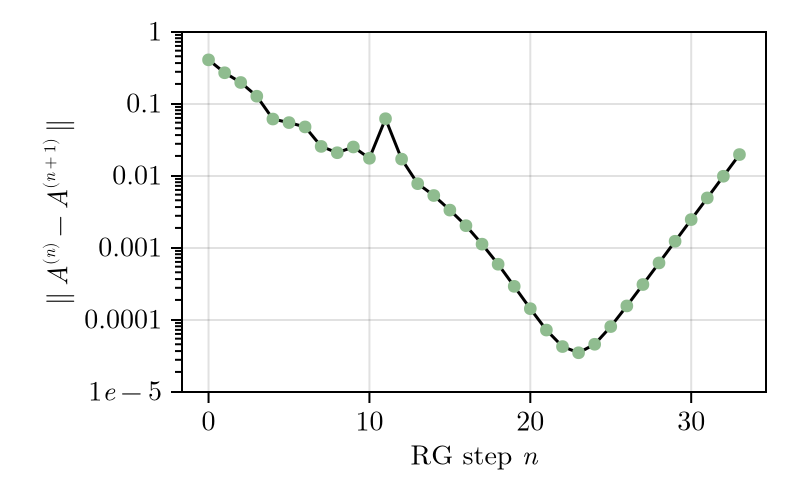

In [7]:

ϕ = (1 + sqrt(5)) / 2
fig = Figure(; size = (ϕ * 250, 250));

ax = Axis(
	fig[1, 1],
	limits = (nothing, nothing, 1e-5, 1),
	ytickformat = int_powers_of_10_scientific_LaTeX,
	xtickformat = int_LaTeX,
	ylabel = L"∥A^{(n)}-A^{(n+1)}∥",
	xlabel = L"\text{RG step } n",
	yscale = log10,
	yminorticksvisible = true,
	yminorticks = IntervalsBetween(10),
)

lines!(ax, 0:length(traj)-2, distances, color = :black);
scatter!(ax, 0:length(traj)-2, distances, color = :darkseagreen);

ax.aspect = ϕ

mkpath("export")

save("export/critical_tensor_convergnece.pdf", fig)

fig


Let us look at the critical tensor itself. It is given by $A^{(23)}$, but Julia's vectors are indexed starting from $1$, so we need traj[24].

In [5]:
A=traj[24];
A_array = (A |> ju_to_py).to_ndarray()
elements_list = []
for index in CartesianIndices(size(A_array))
	push!(elements_list, (index, A_array[index]))
end
sort!(elements_list, by = x -> -abs(x[2]));

We will now plot $\chi=30$ lines from Figure 6. 

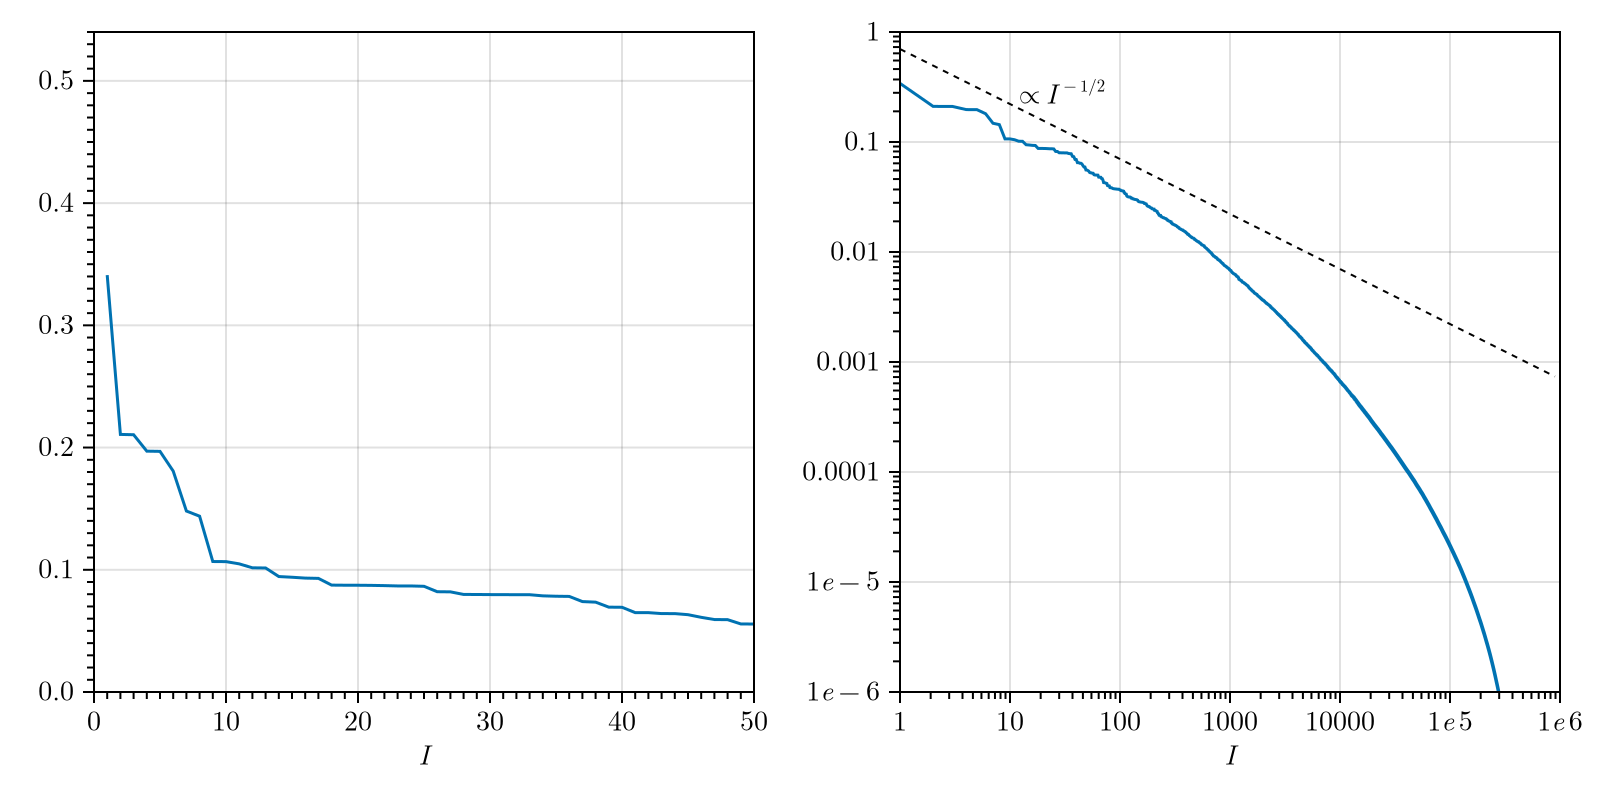

In [7]:

lists = [elements_list]


fig = Figure(; size = (800, 400));

ax2 = Axis(
	fig[1, 2],
	limits = (1, 1e6, 1e-6, 1),
	ytickformat = int_powers_of_10_scientific_LaTeX,
	xtickformat = int_powers_of_10_scientific_LaTeX,
	#xtickformat=int_LaTeX,
	xlabel = L"I",
	yscale = log10,
	xscale = log10,
	yminorticksvisible = true,
	yminorticks = IntervalsBetween(10),
	xminorticksvisible = true,
	xminorticks = IntervalsBetween(10),
)
ax2.aspect = 1

ax1 = Axis(
	fig[1, 1],
	limits = (0, 50, 0, 0.54),
	yticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5],
	xticks = [0, 10, 20, 30, 40, 50],
	ytickformat = float_scientific_LaTeX,
	xtickformat = int_LaTeX,
	xlabel = L"I",
	yminorticksvisible = true,
	yminorticks = IntervalsBetween(10),
	xminorticksvisible = true,
	xminorticks = IntervalsBetween(10),
)
ax1.aspect = 1

cnt = 1
for lst in lists
	tmp = lst .|> x -> x[2]
	tmp = tmp[abs.(tmp).>1e-6]
	lines!(ax2, abs.(tmp))
	#cnt += 1
end

cnt = 1
for lst in lists
	tmp = lst .|> x -> x[2]
	tmp = tmp[abs.(tmp).>0]
	lines!(ax1, abs.(tmp)[1:50])
	cnt += 1
end

#fig[1, 3] = Legend(fig, ax1, L"\text{Bond dimension}")

#Label(fig[2, 1], L"\text{(a)}", justification=:center, tellwidth=false)
#Label(fig[2, 2], L"\text{(b)}", justification=:center, tellwidth=false)

#axislegend(ax,position=:lb)
n = [1, 900000];
lines!(ax2, n, n .|> x -> 0.7 * x^(-1 / 2), linestyle = :dash, color = :black, linewidth = 1)

text!(ax2, 12, 0.2; text = L"\propto I^{-1/2}")

fig

Let us now compute the spectrum of Gilt-TNR at $A^{(23)}$. We run the script "eigensystem.jl" with default parameters. It will print out the first ten eigenvalues and save the corresponding eigensystem in the "eigensystems" directory. We will see one warning here. For this computation, we replaced Z2Tensor with a simple array, and the gauge fixing algorithm tried to fix signs as if there were no Z2 symmetry at all. But symmetry is here, so it cannot fix as many signs as it could without symmetry. 

Note that in the paper we reported positive values. This correpsonds to one additional application of $\mathbb{Z}_2$ flip. In this computation it is better to use "weighted" method for the sign fixing.   

In [8]:
run(`julia --project --threads 40 Lab/eigensystem.jl`)

┌ Warning: construct_linear_system: unable to find 58 independent rows, will fix only 57 dofs
└ @ Main ~/Codes/GILT_TNR_R/GaugeFixing.jl:365


EIGENVALUES for : Jratio=1.0 chi=30 freeze=false  gilt_eps=6.0e-6  cg_eps=1.0e-10
-3.668428680784837 + 0.0im |  Z2 q.n.=-0.9999999998196946 + 0.0im
1.9995747055454296 + 0.0im |  Z2 q.n.=0.9999999944974138 + 0.0im
-1.5328145491406395 + 0.0im |  Z2 q.n.=-0.9999999975749237 + 0.0im
-1.530019959964774 + 0.0im |  Z2 q.n.=-0.9999999995561734 + 0.0im
1.0015205685601702 + 0.0im |  Z2 q.n.=0.9999999769244228 + 0.0im
0.9979854336301693 + 0.0im |  Z2 q.n.=0.9999999937280574 + 0.0im
-0.8869351933066387 + 0.0im |  Z2 q.n.=-0.9999999943839819 + 0.0im
0.6321820091846924 + 0.0im |  Z2 q.n.=0.9999999861064428 + 0.0im
0.5942376455149196 + 0.11936581149730058im |  Z2 q.n.=0.9999999573863051 - 4.225715024953684e-18im
0.5942376455149196 - 0.11936581149730058im |  Z2 q.n.=0.9999999573863051 + 4.225715024953684e-18im


Process(`julia --project --threads 40 Lab/eigensystem.jl`, ProcessExited(0))

We hope the user sees agreement with the spectrum provided in the paper. 

Let us now proceed to the Newton's algorithm. First, we need to find the critical temperature for the rotating algorithm. 